# Entrenamiento

 > #### **Importante**, acuérdate de cambiar el entorno a uno con GPU

Establecemos el tiempo inicial del notebook

In [1]:
import time
t0 = time.time()

In [2]:
EPOCH0 = 0
STEP0 = 0
EPOCHS = 100000
LR = 1e-4
GPUS = 1
GPU_NUMBER = 0
if GPUS > 1:
    BS = 630
else:
    BS = 256 # Con este batch size debería funcionar, pero eres libre de cambiarlo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
MODEL_PATH = #f"/content/drive/MyDrive/path_donde_quieres_guardar_los_resultados_{BS}"

## Instalar librerías

In [ ]:
from IPython.display import clear_output

In [ ]:
!pip install datasets
!pip install tiktoken

clear_output()

## Carga de los datos

In [3]:
from datasets import load_dataset

opus100 = load_dataset("opus100", "en-es")

## Limpieza del dataset

In [4]:
ilegal_chars = ['¢', '¤', '¥', '¦', '§', '¨', '©', '¬', '¯', '¶', '¸', 'À', 'Â', 'Ã', 'Ä', 'Å', 'Æ', 'È', 'Ê', 'Ë', 'Ì', 'Î', 'Ï', 'Ð', 'Ò', 'Ô', 'Õ', 'Ö', '×', 'Ø', 'Ù', 'Û', 'Ý', 'Þ', 'ß', 'à', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'ê', 'ë', 'ì', 'î', 'ï', 'ð', 'ò', 'ô', 'õ', 'ö', '÷', 'ø', 'ù', 'û', 'ü', 'ý', 'þ', 'ÿ']
opus100_cleaned = opus100.filter(lambda ex

dataset keys: dict_keys(['test', 'train', 'validation'])


In [5]:
import tiktoken
enc = tiktoken.get_encoding("cl100k_base")

max_sequence_len = 10
opus100_croped_10 = opus100_cleaned.filter(lambda example: len(enc.encode(example["translation"]["en"])) <= max_sequence_len and len(enc.encode(example["translation"]["es"])) <= max_sequence_len)

train length: 463854,
validation length: 681,
test length: 691


In [6]:
print(f"len dataset train: {len(opus100_croped_10['train'])}, se han eliminado {len(opus100['train']) - len(opus100_croped_10['train'])} ejemplos")
print(f"len dataset validation: {len(opus100_croped_10['validation'])}, se han eliminado {len(opus100['validation']) - len(opus100_croped_10['validation'])} ejemplos")
print(f"len dataset test: {len(opus100_croped_10['test'])}, se han eliminado {len(opus100['test']) - len(opus100_croped_10['test'])} ejemplos")
print(f"En total se han eliminado {len(opus100['train']) + len(opus100['validation']) + len(opus100['test']) - len(opus100_croped_10['train']) - len(opus100_croped_10['validation']) - len(opus100_croped_10['test'])} ejemplos")

train keys: dict_keys(['translation']),
validation keys: dict_keys(['translation']),
test keys: dict_keys(['translation'])


In [7]:
opus100 = opus100_croped_10

train translation keys: dict_keys(['en', 'es']),
validation translation keys: dict_keys(['en', 'es']),
test translation keys: dict_keys(['en', 'es'])


## Dataset y dataloader

Primero creamos la clase `Opus100Dataset`

In [9]:
import torch
from torch.utils.data import Dataset

class Opus100Dataset(Dataset):
    def __init__(self, dataset, source_language, target_language, tokenizer, start_token, end_token, padding_token, max_length):
        self.dataset = dataset
        self.source_language = source_language
        self.target_language = target_language
        self.tokenizer = tokenizer
        self.start_token = start_token
        self.end_token = end_token
        self.padding_token = padding_token
        self.max_length = max_length
    
    def __len__(self):
        return len(self.dataset)
    
    def encode(self, text):
        encoded = self.tokenizer(text)
        encoded = self.start_token + encoded + self.end_token
        if len(encoded) > self.max_length:  # Truncate if too long
            encoded = encoded[:self.max_length]
        else:  # Pad if too short
            encoded = encoded + self.padding_token * (self.max_length - len(encoded))
        return torch.tensor(encoded)
    
    def decode(self, tensor, decoder):
        end_token_position = (tensor == self.end_token[0]).nonzero(as_tuple=True)[0]
        encoded_sentence = tensor[1:end_token_position].tolist()
        return decoder(encoded_sentence)
    
    def __getitem__(self, idx):
        source = self.dataset[idx]["translation"][self.source_language]
        source = self.encode(source)

        target = self.dataset[idx]["translation"][self.target_language]
        target = self.encode(target)
        return source, target


Ahora creamos un objeto para `train`, `validation` y `test`

In [10]:
import tiktoken

encoder = tiktoken.get_encoding("cl100k_base")

start_token = chr(1)
start_token = encoder.encode(start_token)

end_token = chr(2)
end_token = encoder.encode(end_token)

padding_token = chr(3)
padding_token = encoder.encode(padding_token)

max_secuence_length = 10 + 2

train_dataset = Opus100Dataset(opus100["train"], "en", "es", encoder.encode, start_token, end_token, padding_token, max_secuence_length)
validation_dataset = Opus100Dataset(opus100["validation"], "en", "es", encoder.encode, start_token, end_token, padding_token, max_secuence_length)
test_dataset = Opus100Dataset(opus100["test"], "en", "es", encoder.encode, start_token, end_token, padding_token, max_secuence_length)


In [17]:
from torch.utils.data import DataLoader

BS = 256

train_dataloader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BS, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BS, shuffle=False)

## Modelo

Volvemos a escribir todo el código del transformer y creamos un objeto de este

### Clases de bajo nivel

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Embedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, x):
        return self.embedding(x)

class PositionalEncoding(nn.Module):
    def __init__(self, max_sequence_len, embedding_model_dim):
        super().__init__()
        self.embedding_dim = embedding_model_dim
        positional_encoding = torch.zeros(max_sequence_len, self.embedding_dim)
        for pos in range(max_sequence_len):
            for i in range(0, self.embedding_dim, 2):
                positional_encoding[pos, i]     = torch.sin(torch.tensor(pos / (10000 ** ((2 * i) / self.embedding_dim))))
                positional_encoding[pos, i + 1] = torch.cos(torch.tensor(pos / (10000 ** ((2 * (i+1)) / self.embedding_dim))))
        positional_encoding = positional_encoding.unsqueeze(0)
        self.register_buffer('positional_encoding', positional_encoding)

    def forward(self, x):
        x = x * torch.sqrt(torch.tensor(self.embedding_dim))
        sequence_len = x.size(1)
        x = x + self.positional_encoding[:,:sequence_len]
        return x

class ScaledDotProductAttention(nn.Module):
    def __init__(self, dim_embedding):
        super().__init__()
        self.dim_embedding = dim_embedding
    
    def forward(self, query, key, value, mask=None):
        key_trasposed = key.transpose(-1,-2)
        product = torch.matmul(query, key_trasposed)
        scale = product / torch.sqrt(torch.tensor(self.dim_embedding))
        if mask is not None:
            scale = scale.masked_fill(mask == 0, float('-inf'))
        attention_matrix = torch.softmax(scale, dim=-1)
        output = torch.matmul(attention_matrix, value)
        return output

class MultiHeadAttention(nn.Module):
    def __init__(self, heads, dim_embedding):
        super().__init__()
        
        self.dim_embedding = dim_embedding
        self.dim_proyection = dim_embedding // heads
        self.heads = heads
        self.proyection_Q = nn.Linear(dim_embedding, dim_embedding)
        self.proyection_K = nn.Linear(dim_embedding, dim_embedding)
        self.proyection_V = nn.Linear(dim_embedding, dim_embedding)
        self.attention = nn.Linear(dim_embedding, dim_embedding)
        self.scaled_dot_product_attention = ScaledDotProductAttention(self.dim_proyection)
    
    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)
        proyection_Q = self.proyection_Q(Q).view(batch_size, -1, self.heads, self.dim_proyection)
        proyection_K = self.proyection_K(K).view(batch_size, -1, self.heads, self.dim_proyection)
        proyection_V = self.proyection_V(V).view(batch_size, -1, self.heads, self.dim_proyection)
        proyection_Q = proyection_Q.transpose(1,2)
        proyection_K = proyection_K.transpose(1,2)
        proyection_V = proyection_V.transpose(1,2)
        scaled_dot_product_attention = self.scaled_dot_product_attention(proyection_Q, proyection_K, proyection_V, mask=mask)
        concat = scaled_dot_product_attention.transpose(1,2).contiguous().view(batch_size, -1, self.dim_embedding)
        output = self.attention(concat)
        return output

class AddAndNorm(nn.Module):
    def __init__(self, dim_embedding):
        super().__init__()
        self.normalization = nn.LayerNorm(dim_embedding)

    def forward(self, x, sublayer):
        return self.normalization(torch.add(x, sublayer))

class FeedForward(nn.Module):
    def __init__(self, dim_embedding, increment=4):
        super().__init__()
        self.feed_forward = nn.Sequential(
            nn.Linear(dim_embedding, dim_embedding*increment),
            nn.ReLU(),
            nn.Linear(dim_embedding*increment, dim_embedding)
        )
    
    def forward(self, x):
        x = self.feed_forward(x)
        return x

class Linear(nn.Module):
    def __init__(self, dim_embedding, vocab_size):
        super().__init__()
        self.linear = nn.Linear(dim_embedding, vocab_size)
        
    def forward(self, x):
        x = self.linear(x)
        return x

class Softmax(nn.Module):
    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.softmax(x)
        return x

class Dropout(torch.nn.Module):
    def __init__(self, p=0.1):
        super().__init__()
        self.p = p

    def forward(self, x):
        if self.training:
            return torch.nn.functional.dropout(x, p=self.p)
        else:
            return x


### Clases de medio nivel

In [20]:
class EncoderLayer(nn.Module):
    def __init__(self, heads, dim_embedding, prob_dropout=0.1):
        super().__init__()
        self.multi_head_attention = MultiHeadAttention(heads, dim_embedding)
        self.dropout_1 = Dropout(prob_dropout)
        self.add_and_norm_1 = AddAndNorm(dim_embedding)
        self.feed_forward = FeedForward(dim_embedding)
        self.dropout_2 = Dropout(prob_dropout)
        self.add_and_norm_2 = AddAndNorm(dim_embedding)
    
    def forward(self, x):
        multi_head_attention = self.multi_head_attention(x, x, x)
        dropout1 = self.dropout_1(multi_head_attention)
        add_and_norm_1 = self.add_and_norm_1(x, dropout1)
        feed_forward = self.feed_forward(add_and_norm_1)
        dropout2 = self.dropout_2(feed_forward)
        add_and_norm_2 = self.add_and_norm_2(add_and_norm_1, dropout2)
        return add_and_norm_2

class Encoder(nn.Module):
    def __init__(self, heads, dim_embedding, Nx, prob_dropout=0.1):
        super().__init__()
        self.encoder_layers = nn.ModuleList([EncoderLayer(heads, dim_embedding, prob_dropout) for _ in range(Nx)])
    
    def forward(self, x):
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, dim_embedding, max_sequence_len, heads, Nx, prob_dropout=0.1):
        super().__init__()
        self.input_embedding = Embedding(vocab_size, dim_embedding)
        self.positional_encoding = PositionalEncoding(max_sequence_len, dim_embedding)
        self.encoder = Encoder(heads, dim_embedding, Nx, prob_dropout)
    
    def forward(self, x):
        input_embedding = self.input_embedding(x)
        positional_encoding = self.positional_encoding(input_embedding)
        encoder = self.encoder(positional_encoding)
        return encoder

class DecoderLayer(nn.Module):
    def __init__(self, heads, dim_embedding, prob_dropout=0.1):
        super().__init__()
        self.masked_multi_head_attention = MultiHeadAttention(heads, dim_embedding)
        self.dropout_1 = Dropout(prob_dropout)
        self.add_and_norm_1 = AddAndNorm(dim_embedding)
        self.encoder_decoder_multi_head_attention = MultiHeadAttention(heads, dim_embedding)
        self.dropout_2 = Dropout(prob_dropout)
        self.add_and_norm_2 = AddAndNorm(dim_embedding)
        self.feed_forward = FeedForward(dim_embedding)
        self.dropout_3 = Dropout(prob_dropout)
        self.add_and_norm_3 = AddAndNorm(dim_embedding)
    
    def forward(self, x, encoder_output, mask=None):
        Q = x
        K = x
        V = x
        masked_multi_head_attention = self.masked_multi_head_attention(Q, K, V, mask=mask)
        dropout1 = self.dropout_1(masked_multi_head_attention)
        add_and_norm_1 = self.add_and_norm_1(dropout1, x)

        Q = add_and_norm_1
        K = encoder_output
        V = encoder_output
        encoder_decoder_multi_head_attention = self.encoder_decoder_multi_head_attention(Q, K, V)
        dropout2 = self.dropout_2(encoder_decoder_multi_head_attention)
        add_and_norm_2 = self.add_and_norm_2(dropout2, add_and_norm_1)

        feed_forward = self.feed_forward(add_and_norm_2)
        dropout3 = self.dropout_3(feed_forward)
        add_and_norm_3 = self.add_and_norm_3(dropout3, add_and_norm_2)

        return add_and_norm_3

class Decoder(nn.Module):
    def __init__(self, heads, dim_embedding, Nx, prob_dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([DecoderLayer(heads, dim_embedding, prob_dropout) for _ in range(Nx)])
    
    def forward(self, x, encoder_output, mask=None):
        for decoder_layer in self.layers:
            x = decoder_layer(x, encoder_output, mask)
        return x

class TransformerDecoder(nn.Module):
    def __init__(self, heads, dim_embedding, Nx, vocab_size, max_sequence_len, prob_dropout=0.1):
        super().__init__()
        self.embedding = Embedding(vocab_size, dim_embedding)
        self.positional_encoding = PositionalEncoding(max_sequence_len, dim_embedding)
        self.decoder = Decoder(heads, dim_embedding, Nx, prob_dropout)
        self.linear = Linear(dim_embedding, vocab_size)
        self.softmax = Softmax()
    
    def forward(self, x, encoder_output, mask=None):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.decoder(x, encoder_output, mask)
        x = self.linear(x)
        x = self.softmax(x)
        return x


### Clase de alto nivel

In [21]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, dim_embedding, max_sequence_len, heads, Nx, prob_dropout=0.1):
        super().__init__()
        self.encoder = TransformerEncoder(vocab_size, dim_embedding, max_sequence_len, heads, Nx, prob_dropout)
        self.decoder = TransformerDecoder(heads, dim_embedding, Nx, vocab_size, max_sequence_len, prob_dropout)
    
    def forward(self, source, target, mask=None):
        encoder_output = self.encoder(source)
        decoder_output = self.decoder(target, encoder_output, mask)
        return decoder_output


### Transformer

In [22]:
vocab_size = encoder.n_vocab
dim_embedding = 512
heads = 8
Nx = 6
prob_dropout = 0.1
print(f"vocab_size: {vocab_size}, dim_embedding: {dim_embedding}, max_secuence_length: {max_secuence_length}, heads: {heads}, Nx: {Nx}, prob_dropout: {prob_dropout}")

transformer = Transformer(vocab_size=vocab_size,
                          dim_embedding=dim_embedding,
                          max_sequence_len=max_secuence_length,
                          heads=heads,
                          Nx=Nx,
                          prob_dropout=prob_dropout)


vocab_size: 100277, dim_embedding: 512, max_secuence_length: 12, heads: 8, Nx: 6, prob_dropout: 0.1


In [23]:
# Data parallel
if torch.cuda.device_count() > 1:
    print(f"Let's use {torch.cuda.device_count()} GPUs!")
    transformer = nn.DataParallel(transformer)

    def create_mask(sequence_len):
        mask = torch.tril(torch.ones((2*sequence_len, sequence_len)))
        return mask
else:
    print(f"Let's use {torch.cuda.device_count()} GPUs!")
    def create_mask(sequence_len):
        mask = torch.tril(torch.ones((sequence_len, sequence_len)))
        return mask


Let's use 1 GPUs!


In [24]:
mask = create_mask(max_secuence_length)

## Entrenamiento

### Función de pérdida

Usamos la clase creada para el label smoothing

In [25]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1, dim=-1, ignore_index=-100):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.classes = classes
        self.dim = dim
        self.ignore_index = ignore_index

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.classes - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
            mask = (target == self.ignore_index).unsqueeze(1).expand_as(true_dist)
            if mask.any():
                true_dist[mask] = 0
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

loss_function = LabelSmoothingLoss(classes=vocab_size, smoothing=0.1, ignore_index=padding_token[0])

### Optimizador

Creamos el optimizador con los parámetros del paper e implementamos el scheduler del learning rate

In [26]:
optimizer = torch.optim.Adam(transformer.parameters(), lr=LR, betas=(0.9, 0.98), eps=1e-9)

Vamos a crear dos clases para guardar el step y el learning rate por si se quiere continuar el entrenamiento

In [27]:
class Step():
    def __init__(self):
        self.step = 0
    
    def set_step(self, st):
        self.step = st
    
    def get_step(self):
        return int(self.step)

class LearningRate():
    def __init__(self):
        self.lr = 0
    
    def set_lr(self, l_r_):
        self.lr = l_r_
    
    def get_lr(self):
        return self.lr

actual_step = Step()
actual_lr = LearningRate()

In [28]:
def calculate_lr(step_num, dim_embeding_model=512, warmup_steps=4000):
    step_num += 1e-7 # Avoid division by zero
    step_num += STEP0
    actual_step.set_step(step_num)
    lr = (dim_embeding_model**-0.5) * min(step_num**-0.5, step_num*(warmup_steps**-1.5))
    actual_lr.set_lr(lr)
    return lr

lr_lambda = lambda step: calculate_lr(step, dim_embeding_model=dim_embedding)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

### Ciclo de entrenamiento

In [29]:
import numpy as np

def train_loop(dataloader, model, loss_fn, optimizer, device, mask, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    mean_loss = 0
    lr_list = []
    for batch, (src, trg) in enumerate(dataloader):
        src = src.to(device)
        trg = trg.to(device)
        mask = mask.to(device)

        pred = model(src, trg, mask)
        loss = loss_fn(pred.transpose(1, 2), trg)
        mean_loss += loss.item()

        # lr = optimizer.param_groups[0]['lr']
        lr = actual_lr.get_lr()
        lr_list.append(lr)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(src)
            print(f"loss: {loss:0.10f} [{current:>5d}/{size:>5d}] - epoch {epoch} - lr {lr}")
    return mean_loss/num_batches, np.array(lr_list)

def validation_loop(dataloader, model, loss_fn, device, mask):
    num_batches = len(dataloader)
    validation_loss = 0
    with torch.no_grad():
        for src, trg in dataloader:
            src = src.to(device)
            trg = trg.to(device)
            mask = mask.to(device)

            pred = model(src, trg, mask)
            validation_loss += loss_fn(pred.transpose(1, 2), trg).item()
    validation_loss /= num_batches
    print(f"Avg validation loss: {validation_loss:>8f}")
    return validation_loss


In [30]:
# Device
if torch.cuda.device_count() > 1 and GPUS > 1:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using {torch.cuda.device_count()} GPUs")
else:
    if torch.cuda.is_available():
        device = torch.device(f"cuda:{GPU_NUMBER}")
        print(f"Using GPU {GPU_NUMBER}")
    else:
        device = torch.device("cpu")
        print("Using CPU")

transformer = transformer.to(device)

Using GPU 0


Creamos una función que calcula el tiempo transcurrido

In [31]:
def elapsed_time(t0):
    t = time.time() - t0  # tiempo transcurrido en segundos

    # Convertir el tiempo a días, horas, minutos y segundos
    days, t = divmod(t, 86400)  # 86400 segundos en un día
    hours, t = divmod(t, 3600)  # 3600 segundos en una hora
    minutes, seconds = divmod(t, 60)  # 60 segundos en un minuto

    return int(days), int(hours), int(minutes), int(seconds)

def elapsed_seconds(days, hours, minutes, seconds):
    return days * 86400 + hours * 3600 + minutes * 60 + seconds


Cargamos los pesos si no partimos desde cero

In [32]:
if EPOCH0 != 0 or STEP0 != 0:
    if GPUS > 1:
        print(f"Loading model from {MODEL_PATH}/transformer_{EPOCH0}_{STEP0}.pth")
        transformer.load_state_dict(torch.load(f'{MODEL_PATH}/transformer_{EPOCH0}_{STEP0}.pth'))
        print(f"Model loaded from {MODEL_PATH}/transformer_{EPOCH0}_{STEP0}.pth")
    else:
        print(f"Loading model from {MODEL_PATH}/transformer_model_{EPOCH0}_{STEP0}.pth")
        weights = f"{MODEL_PATH}/transformer_model_{EPOCH0}_{STEP0}.pth"
        transformer = torch.load(weights, map_location=device)
        if isinstance(transformer, nn.DataParallel):
            print("Transforming model to nn.Module")
            transformer = transformer.module
        print(f"Model loaded from {MODEL_PATH}/transformer_{EPOCH0}_{STEP0}.pth")

    print(f"load best validation loss from {MODEL_PATH}/best_validation_loss_{EPOCH0}_{STEP0}.npy")
    best_loss = np.load(f'{MODEL_PATH}/validation_loss_{EPOCH0}_{STEP0}.npy')
    print(f"best validation loss: {best_loss}")
else:
    best_loss = 1000000


Creamos listas donde se guardarán los valores de pérdida y learning rate

In [33]:
train_loss_list = []
train_lr_list = []
validation_loss_list = []
train_loss_list = np.array(train_loss_list)
train_lr_list = np.array(train_lr_list)
validation_loss_list = np.array(validation_loss_list)

In [ ]:
import os

best_loss = 1000000
max_seconds = 60*60*11 + 60*30 # 11 horas y 30 minutos

for epoch in range(EPOCH0, EPOCHS, 1):
    days, hours, minutes, seconds = elapsed_time(t0)
    print(f"\nEpoch {epoch}\n-------------------------------, {days} days, {hours} hours, {minutes} minutes, {seconds} seconds")
    train_loss, train_lr = train_loop(train_dataloader, transformer, loss_function, optimizer, device, mask, epoch)
    validation_loss = validation_loop(validation_dataloader, transformer, loss_function, device, mask)

    train_loss_list = np.append(train_loss_list, train_loss)
    train_lr_list = np.append(train_lr_list, train_lr)
    validation_loss_list = np.append(validation_loss_list, validation_loss)

    if validation_loss < best_loss:
        best_loss = validation_loss
        if not os.path.exists(MODEL_PATH):
            os.makedirs(MODEL_PATH)
        # Delete all files in folder
        files = os.listdir(MODEL_PATH)
        for f in files:
            os.remove(os.path.join(MODEL_PATH, f))
        torch.save(transformer.state_dict(), f'{MODEL_PATH}/transformer_{epoch+1}_{actual_step.get_step()}.pth')
        torch.save(transformer, f'{MODEL_PATH}/transformer_model_{epoch+1}_{actual_step.get_step()}.pth')
        val = np.array([validation_loss])
        np.save(f'{MODEL_PATH}/validation_loss_{epoch+1}_{actual_step.get_step()}.npy', val)
        print(f"Best model saved with loss {best_loss} at epoch {epoch}, in {time.time()-t0} ms, with lr {train_lr[-1]} and in step {actual_step.get_step()} --> {MODEL_PATH}/transformer_{epoch+1}_{actual_step.get_step()}.pth")

    days, hours, minutes, seconds = elapsed_time(t0)
    train_elapsed_seconds = elapsed_seconds(days, hours, minutes, seconds)
    if train_elapsed_seconds > max_seconds:
        print("Time out!")
        break

np.save(f'{MODEL_PATH}/train_loss_list.npy', train_loss_list)
np.save(f'{MODEL_PATH}/train_lr_list.npy', train_lr_list)
np.save(f'{MODEL_PATH}/validation_loss_list.npy', validation_loss_list)

print("Done!")

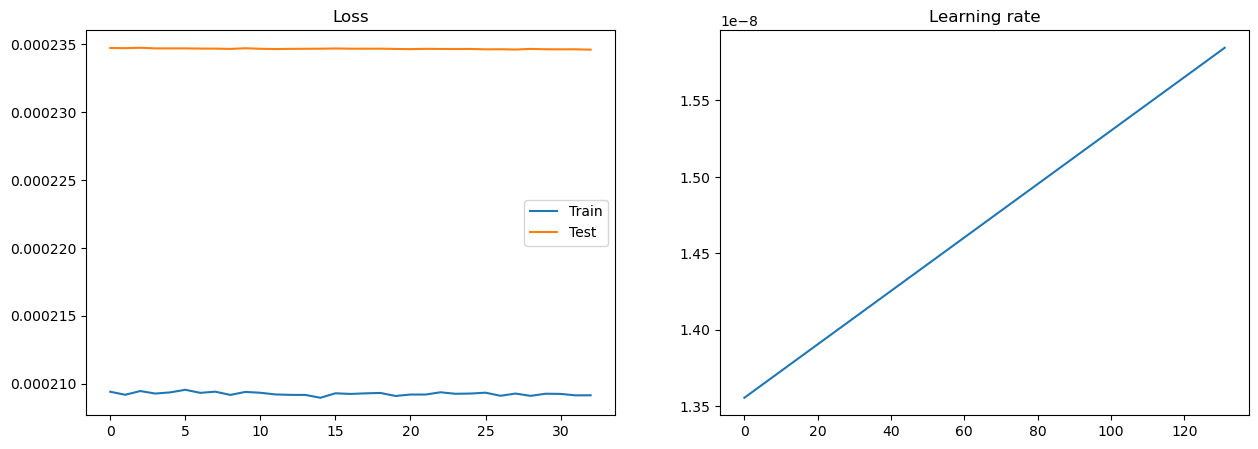

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(train_loss_list)
axs[0].plot(validation_loss_list)
axs[0].set_title("Loss")
axs[0].legend(["Train", "Test"])
axs[1].plot(train_lr_list)
axs[1].set_title("Learning rate")
plt.show()